<a href="https://colab.research.google.com/github/jej0312/DM_TA/blob/main/3_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering (군집분석)
- TA: 전은지 (Eunji Jeon)  
- Dept. of Industrial Engineering, Yonsei Univ (Industrial Statistics Lab; ISL 산업통계연구실)
- 문의: `jej_0312_@naver.com`

- 확진자 현황 확인하기

- Unsupervised Learning: Y label이 없는 데이터에서 패턴을 찾는 방법
- Clustering: 거리가 가까운 관측치들 간 유사한 특징이 있을 것이라는 가정을 기반으로 변수들을 군집화
  - 정답이 없으므로 탐색 인사이트 용도로 사용
  - 대부분 optimization 문제를 푸는 경우가 많음
  - 1) 계층적 클러스터링 (hierarchical clustering)과 2) 비계층적 클러스터링(K-means clustering)으로 구분됨
    - 1) 거리행렬을 기반으로 가까운 대상끼리 순차적으로 그룹을 할당
    - 2) 랜덤한 시작점에서 해당 점과 가까운 대상 간 그룹 할당
  - **클러스터링 진행 결과 평가: connectivity , sihouette, dunn**

- 이상치가 존재할 경우 클러스터링 진행 시 영향을 많이 받을 수 있으므로 사전에 제거 과정이 필요

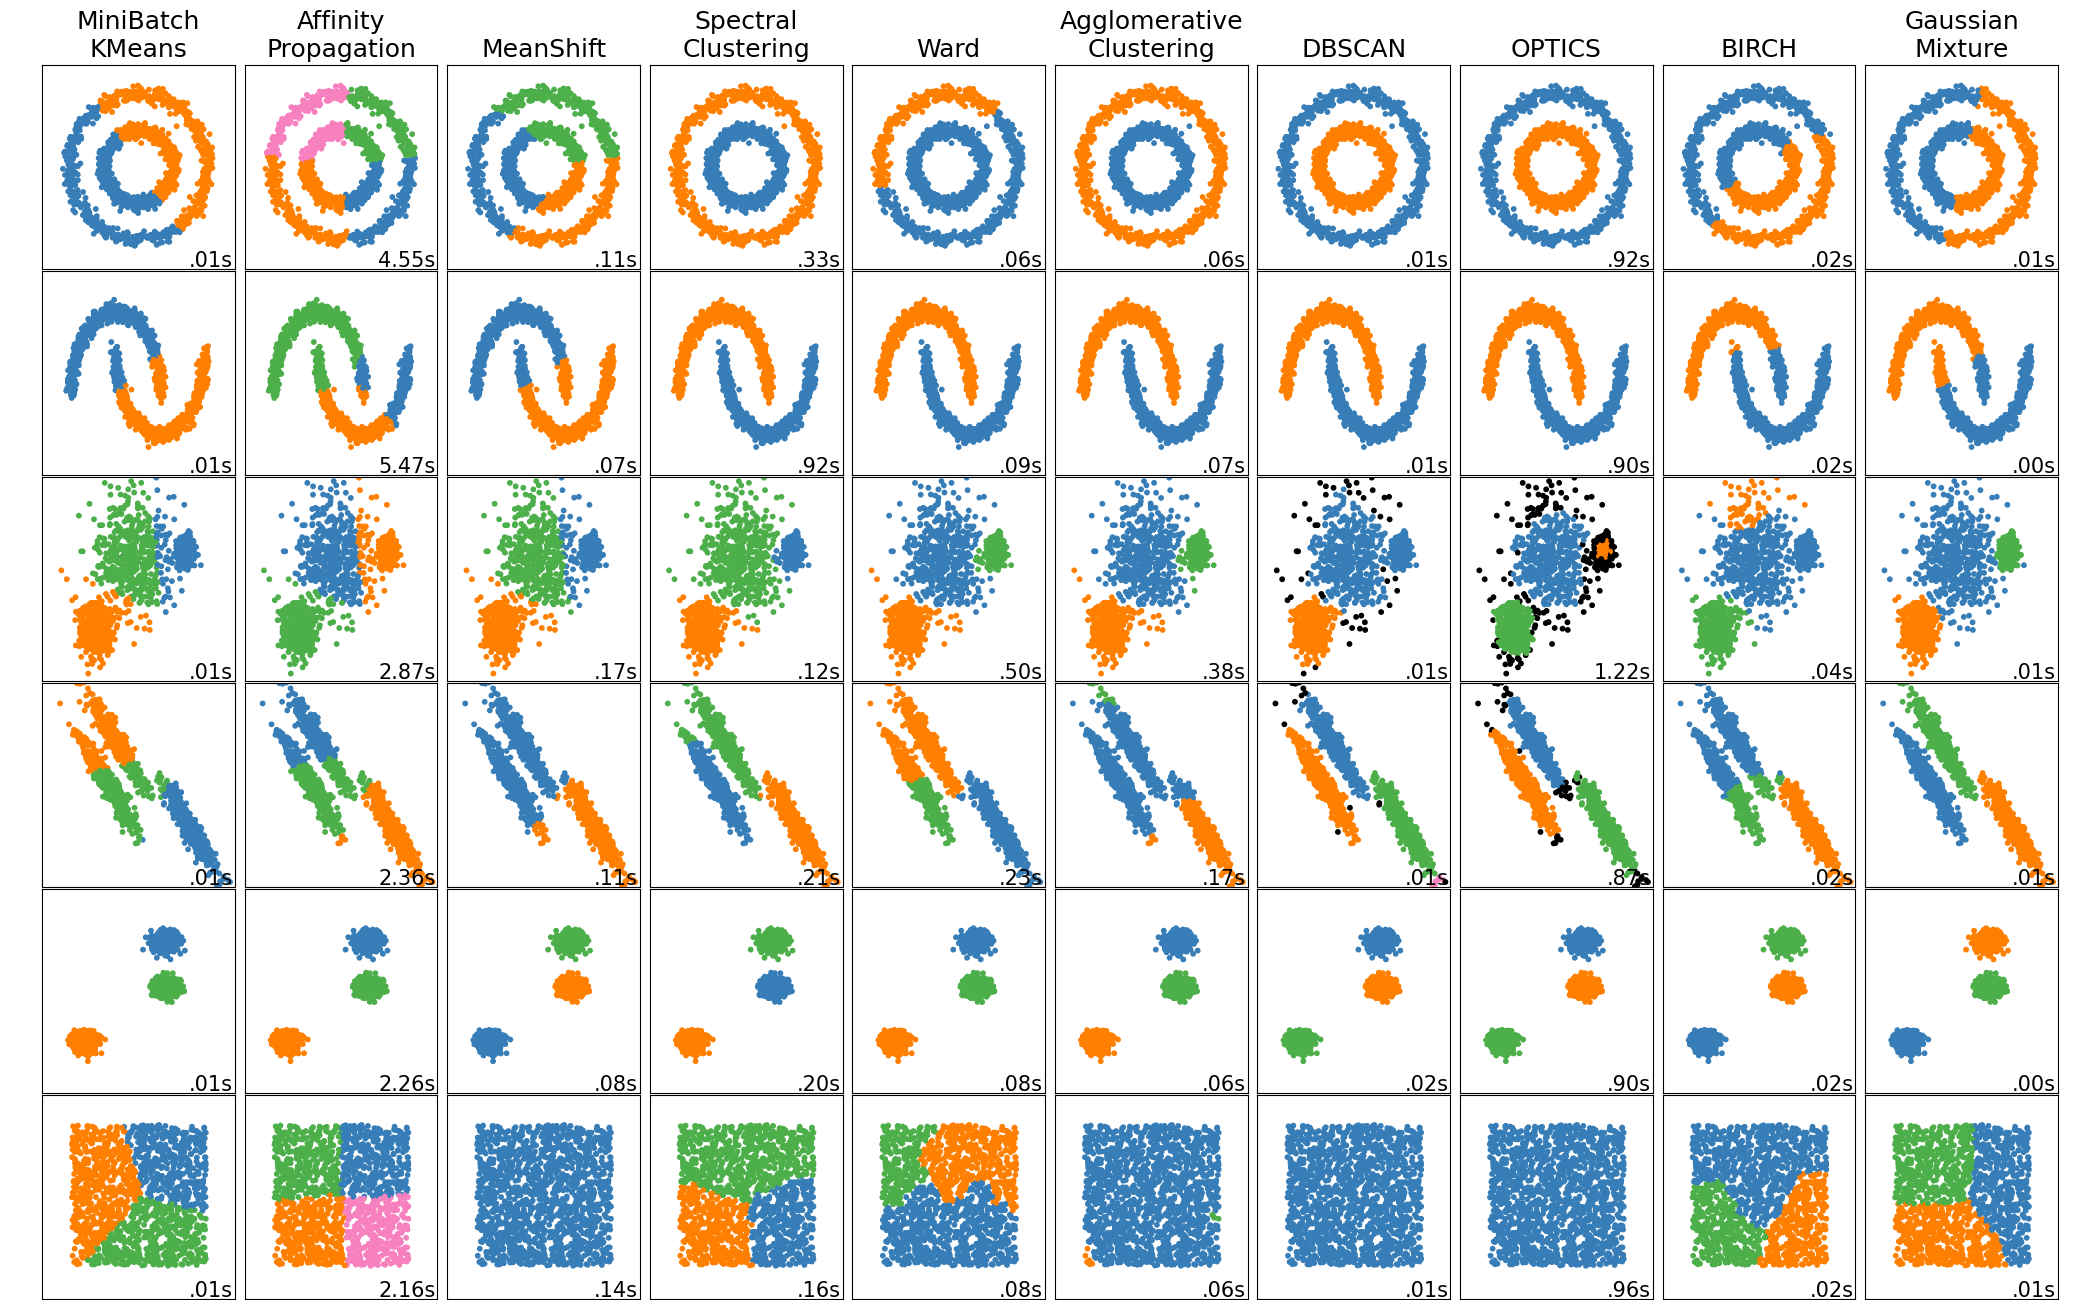

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import pandas as pd 
data = pd.read_csv('https://raw.githubusercontent.com/jej0312/DM_TA/main/data/fa_data_bfi.csv')

In [3]:
from IPython.display import display
display(data.head())
print('\n', data.shape)

,Neuroticism,Extraversion,Conscientiousness,Agreeableness,Openess
0,-0.439830,0.103897,-1.216713,-0.696215,-1.519449
1,0.084369,0.559311,-0.601521,-0.189341,-0.248384
2,0.520534,0.318235,0.025646,-0.751136,0.204503
3,-0.197064,0.057696,-1.019263,0.064286,-1.029492
4,-0.329835,0.408754,-0.058843,-0.820454,-0.691042



 (2436, 5)


In [4]:
# 이상치 제거 함수 (1Q - 1.5*IQR, 3Q + 1.5*IQR 을 넘어가는 값을 가진 행을 제거)
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
  quantile_25 = np.percentile(df[column].values, 25)
  quantile_75 = np.percentile(df[column].values, 75)

  IQR = quantile_75 - quantile_25
  IQR_weight = IQR*weight
  
  lowest = quantile_25 - IQR_weight
  highest = quantile_75 + IQR_weight
  
  outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
  return outlier_idx

In [5]:
for col in data.columns:
    outlier_idx = get_outlier(df=data, column=col, weight=1.5)
    data.drop(outlier_idx, axis=0, inplace=True)

In [6]:
display(data.head())
print('\n', data.shape)

,Neuroticism,Extraversion,Conscientiousness,Agreeableness,Openess
0,-0.439830,0.103897,-1.216713,-0.696215,-1.519449
1,0.084369,0.559311,-0.601521,-0.189341,-0.248384
2,0.520534,0.318235,0.025646,-0.751136,0.204503
3,-0.197064,0.057696,-1.019263,0.064286,-1.029492
4,-0.329835,0.408754,-0.058843,-0.820454,-0.691042



 (2335, 5)


- large scale 데이터를 사용할 경우 계산량이 많아지며, 클러스터링 시 값의 range의 영향을 받기 때문에 표준화/scaling이 필요

In [7]:
data.describe() # 기초통계량

,Neuroticism,Extraversion,Conscientiousness,Agreeableness,Openess
count,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000
mean,0.003113,0.030340,0.025799,0.054182,0.003259
std,0.913940,0.836298,0.821891,0.764686,0.808914
min,-2.011680,-2.287489,-2.320576,-2.107187,-2.294768
25%,-0.718653,-0.498024,-0.526410,-0.439648,-0.570231
50%,-0.056327,0.097684,0.088043,0.142092,0.025512
75%,0.650523,0.655036,0.634843,0.614244,0.609261
max,2.551124,2.336969,1.893386,2.179653,2.011314


In [8]:
from sklearn.preprocessing import StandardScaler
scaled = StandardScaler().fit_transform(data)

In [9]:
scaled = pd.DataFrame(scaled, columns = data.columns)
scaled.describe() # 기초통계량

,Neuroticism,Extraversion,Conscientiousness,Agreeableness,Openess
count,2.335000e+03,2.335000e+03,2.335000e+03,2.335000e+03,2.335000e+03
mean,-1.435920e-17,-1.359845e-17,4.052195e-17,1.141129e-18,5.230173e-17
std,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00
min,-2.204987e+00,-2.772128e+00,-2.855461e+00,-2.827083e+00,-2.841488e+00
25%,-7.899000e-01,-6.319241e-01,-6.720208e-01,-6.459321e-01,-7.091154e-01
50%,-6.505121e-02,8.054349e-02,7.574925e-02,1.149865e-01,2.751602e-02
75%,7.085238e-01,7.471380e-01,7.411858e-01,7.325648e-01,7.493164e-01
max,2.788539e+00,2.758732e+00,2.272792e+00,2.780129e+00,2.482941e+00


# 계층적 클러스터링 (Hierarchical Clustering)
- 거리 행렬을 기반으로 유사한 관측치끼리 묶음
  - 모든 관측치들 간 거리를 계산함
- 거리를 어떻게 계산할지에 따라 linkage method 구분  
  1) 최단연결법 (single): 생성된 군집에서 중심과 거리가 **가까운** 관측치끼리 군집화  
  2) 최장연결법 (complete): 생성된 군집에서 중심과 거리가 **먼** 관측치끼리 군집화  
  3) 평균연결법 (average): 군집 내 모든 데이터와 다른 군집 내 모든 데이터 간의 거리 **평균**을 계산하여 군집화  
  4) 중앙연결법 (centroid): 군집 내 **centroid**과 다른 군집 내 median까지의 거리를 계산하여 가까운 것끼리 군집화  
$$\vec{\mu}(\omega_i)\cdot\vec{\mu}(\omega_j)=(\frac{1}{N_i}\sum_{d_m\in\omega_i}\vec{d_m})\cdot(\frac{1}{N_j}\sum_{d_n\in\omega_j}\vec{d_n})=\frac{1}{N_i}\frac{1}{N_j}\sum_{d_m\in\omega_i}\sum_{d_n\in\omega_j}{\vec{d_m}\cdot\vec{d_n}}$$
  5) 와드연결법 (ward): 거리가 아닌, 군집 내 오차 제곱합(within group sum of squares)이 최소가 되도록 최소가 되도록 군집화
$$SSE=\sum^K_{i=1}SSE_i=\sum^{K}_{i=1}\sum^{n_i}_{j=1}\sum^{m}_{k=1}(x_{ijk}-\bar{x}_{ik})^2$$

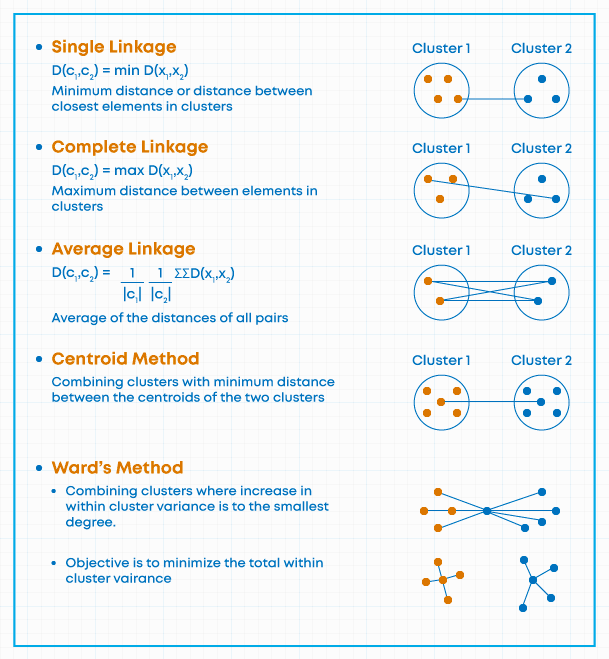
- [출처](https://dataaspirant.com/hierarchical-clustering-algorithm/)

- 장점
    - 클러스터 생성 과정에 대해 이해할 수 있음
    - 사전에 클러스터의 수를 지정하지 않아도 됨
    - 덴드로그램을 통해 클러스터의 수를 결정하는 과정이 쉬움
- 한계
    - 방대한 양의 데이터에서 제대로 작동하지 않을 수 있음
    - 두 클러스터를 결합한 이후에는 그 전으로 돌아갈 수 없음
    - 노이즈 및 이상값에 대해 민감
    - 데이터의 순서가 최종 결과에 영향을 줄 수 있음
- [참고](https://dataaspirant.com/hierarchical-clustering-algorithm/)

## Step 1. 거리 계산에 따른 클러스터링
- `scipy.cluster.hierarchy`의 `linkage` 사용
- [제공하는 linkage 방식](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage)
  -  single, complete, average, centroid, median, ward, weighted
- [제공하는 거리 계산 방식](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist)
  - euclidean distance: real-valued 차원에서 각 관측치들의 location을 기반으로 측정 (Euclidean, manhattan, ...)
    - centroid, median, ward linkage method를 사용할 경우 Euclidean pairwise metric만 활용 가능
  - non-euclidean distance: 각 관측치의 거리가 아닌, properties에 의해 측정 (e.g. cosine, jaccard, ...) 
    - 이 외에 clustroid 등의 method를 사용할 때 사용 가능

In [49]:
data_prime = scaled.copy()

In [50]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
clusters = linkage(y=data_prime, method='complete', metric='euclidean')

## Step 2. 군집 수 결정
- 덴드로그램 (dendrogram): 각 단계에서 군집이 어떻게 형성되는지 확인하고 형성된 군집의 유사성(또는 거리) 수준을 평가  
  - 덴드로그램을 더 높게 커팅할수록 최종 군집 수는 더 작지만 유사성 수준은 더 낮아짐
  - 덴드로그램을 더 낮게 커팅할수록 유사성 수준은 더 높지만 최종 군집 수는 더 많아짐
  - 일부 데이터 집합의 경우 평균, 중심, 중위수 및 Ward의 연결 방법으로 계층적 덴드로그램이 생성되지 않음. (결합 거리가 각 단계에서 항상 증가하지 않을 수 있음)

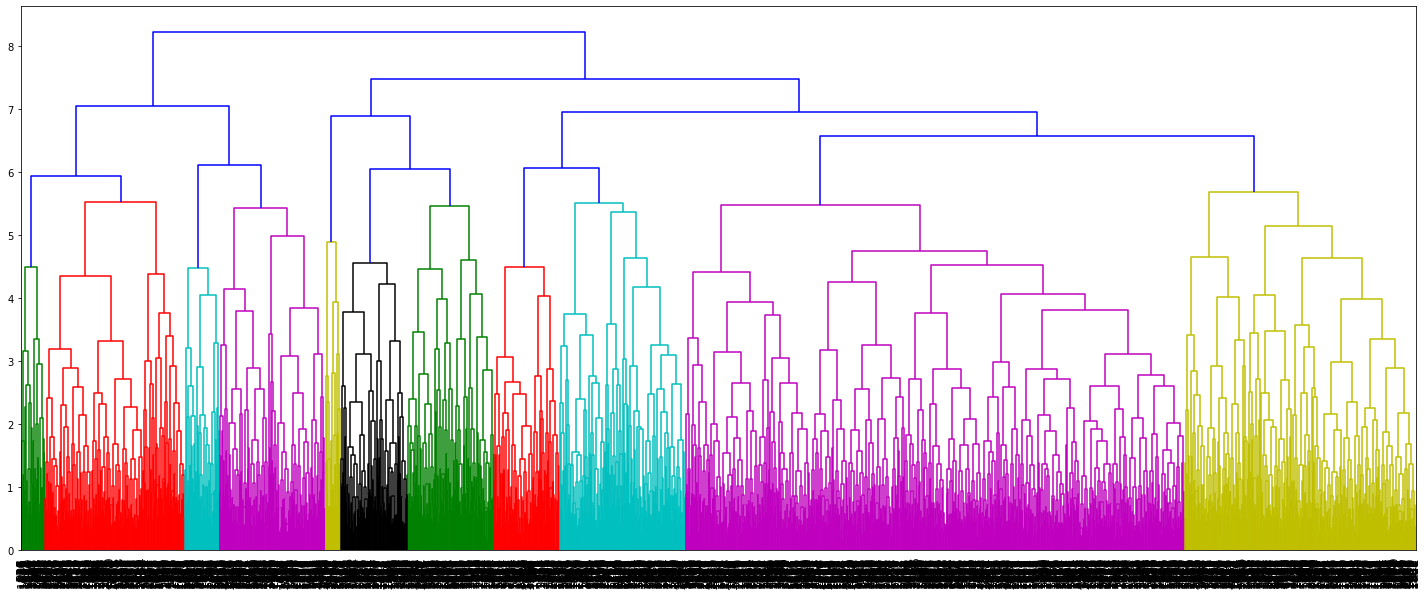

In [13]:
import matplotlib.pyplot as plt
plt.figure( figsize = (25, 10) )
dendrogram(clusters, leaf_rotation=90, leaf_font_size=12,)
plt.show()

- [`fcluster`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html)을 사용하여 덴드로그램 결과에 기반한 clustering을 진행
- 일반적으로는 (cophenetic)`'distance'` threshold(t)를 기준으로 구분
  - 이 외에도 inconsistent, maxclust, ... 등의 방식이 있음

In [14]:
cut_tree = fcluster(clusters, t=7, criterion='distance')
cut_tree

array([1, 4, 3, ..., 3, 3, 3], dtype=int32)

In [15]:
pd.Series(cut_tree).value_counts()

4    1542
3     283
1     275
2     235
dtype: int64

## Step 3. Evaluation
- 군집 내 비유사성 (within dissimilarities)는 작고 군집 간 비유사성 (between dissimilarities)는 크도록 생성
- 이 때, Silhouette coefficient (실루엣 계수)는 각 관측치와 주위 관측치과의 거리 계산을 통해 군집 내 비유사성과 군집 간 비유사성의 정도를 평가
  - 데이터 양이 많아질수록 time complexity가 높음
  - 구체적인 계산과정은 [다음](https://studying-haeung.tistory.com/10)을 참고

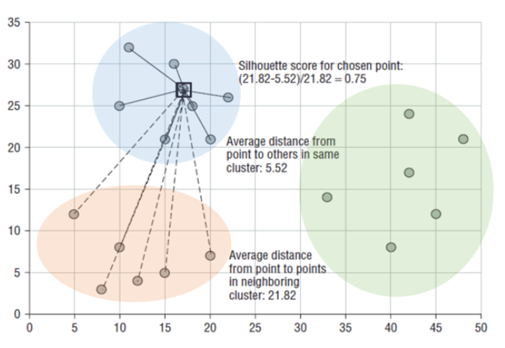
- [출처](https://ariz1623.tistory.com/224)

- `silhouette_samples`를 통해 coefficient를 계산, `silhouette_score`를 통해 모든 coefficient의 평균을 계산

In [16]:
from sklearn.metrics import silhouette_samples, silhouette_score
score_samples = silhouette_samples(data_prime, cut_tree)
print('Silhouette Score:', score_samples[:5], '\nSilhouette Score shape:', score_samples.shape, '\n')

average_score = silhouette_score(data_prime, cut_tree)
# np.mean(score_samples) == average_score: True
print('Silhouette Average Score:{0:.3f}'.format(average_score))

Silhouette Score: [0.26399624 0.04965367 0.02685061 0.23496799 0.11082033] 
Silhouette Score shape: (2335,) 

Silhouette Average Score:0.059


1. 전체 실루엣 계수(0~1)의 평균값이 1에 가까울수록 클러스터링이 잘 진행된 것  
1. 개별 클러스터의 실루엣 계수 평균값의 편차가 작아야 함
  - 클러스터 내 실루엣 계수 평균값을 확인하여, 1에 가까운 클러스터를 'clear-cut cluster', 0에 가까운 클러스터를 'weak cluster'로 표현

In [17]:
data_prime['hc_cluster'] = cut_tree
data_prime['silhouette_coeff'] = score_samples
data_prime

,Neuroticism,Extraversion,Conscientiousness,Agreeableness,Openess,hc_cluster,silhouette_coeff
0,-0.484757,0.087974,-1.512096,-0.981524,-1.882814,1,0.263996
1,0.088926,0.632650,-0.763428,-0.318530,-0.311154,4,0.049654
2,0.566265,0.344323,-0.000187,-1.053360,0.248836,3,0.026851
3,-0.219074,0.032717,-1.271806,0.013216,-1.276987,1,0.234968
4,-0.364378,0.452584,-0.103007,-1.144029,-0.858497,1,0.110820
...,...,...,...,...,...,...,...
2330,1.192595,1.276914,-0.168496,-0.098960,-1.108426,4,0.041472
2331,1.428117,-1.414563,-0.158201,-1.570383,0.505457,3,0.027685
2332,0.798209,0.265352,-0.746378,-0.486530,1.264070,3,-0.045137
2333,-0.247750,0.826233,0.926490,-1.455368,1.139852,3,0.096256


In [18]:
# 군집별 평균 silhouette_score 값
print(data_prime.groupby('hc_cluster')['silhouette_coeff'].mean())
print('표준편차:', data_prime.groupby('hc_cluster')['silhouette_coeff'].mean().std())

hc_cluster
1    0.155768
2    0.082219
3    0.057706
4    0.038121
Name: silhouette_coeff, dtype: float64
표준편차: 0.05147475615133177


## Step 4. EDA

In [19]:
# 군집별 통계(평균)
cluster_g = data_prime.groupby('hc_cluster')
cluster_g.mean()

,Neuroticism,Extraversion,Conscientiousness,Agreeableness,Openess,silhouette_coeff
hc_cluster,,,,,,
1,-0.202224,-0.476430,-0.354750,0.008229,-1.193593,0.155768
2,0.641531,-0.987144,0.818133,0.047872,0.429910,0.082219
3,-0.202057,-0.504072,-0.200515,-1.428871,0.369076,0.057706
4,-0.024621,0.327918,-0.024617,0.253474,0.079611,0.038121


In [20]:
# 군집별 통계(표준편차)
cluster_g.std()

,Neuroticism,Extraversion,Conscientiousness,Agreeableness,Openess,silhouette_coeff
hc_cluster,,,,,,
1,0.961289,0.731722,1.000291,0.855926,0.599619,0.090031
2,0.898211,0.795442,0.797586,0.970096,1.129314,0.121418
3,0.873832,1.061641,1.110190,0.690878,1.062821,0.136505
4,1.005253,0.879968,0.939506,0.845658,0.858583,0.126445


- Cluster1: 개방적이지 않은(-O) 사람
- Cluster2: 신경질적(N)인데 외향적이지 않으며(-E) 성실한(C) 사람
- Cluster3: 외향적이지 않고(-E) 쾌활하지 않은(-A) 사람
- Cluster4: 큰 특징이 존재하지 않는 사람

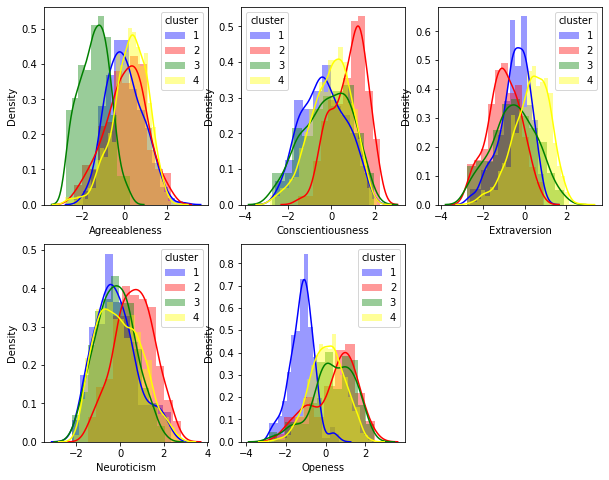

In [21]:
# 시각화방법 1
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8)) 
plt.subplot(2,3,1) 
sns.distplot(data_prime[data_prime.hc_cluster == 1]["Agreeableness"], 
             color="blue", label=1)
sns.distplot(data_prime[data_prime.hc_cluster == 2]["Agreeableness"], 
             color="red", label=2)
sns.distplot(data_prime[data_prime.hc_cluster == 3]["Agreeableness"], 
             color="green", label=3)
sns.distplot(data_prime[data_prime.hc_cluster == 4]["Agreeableness"], 
             color="yellow", label=4)
plt.legend(title="cluster")


plt.subplot(2,3,2) 
sns.distplot(data_prime[data_prime.hc_cluster == 1]["Conscientiousness"], 
             color="blue", label=1)
sns.distplot(data_prime[data_prime.hc_cluster == 2]["Conscientiousness"], 
             color="red", label=2)
sns.distplot(data_prime[data_prime.hc_cluster == 3]["Conscientiousness"], 
             color="green", label=3)
sns.distplot(data_prime[data_prime.hc_cluster == 4]["Conscientiousness"], 
             color="yellow", label=4)
plt.legend(title="cluster")


plt.subplot(2,3,3)
sns.distplot(data_prime[data_prime.hc_cluster == 1]["Extraversion"], 
             color="blue", label=1)
sns.distplot(data_prime[data_prime.hc_cluster == 2]["Extraversion"], 
             color="red", label=2)
sns.distplot(data_prime[data_prime.hc_cluster == 3]["Extraversion"], 
             color="green", label=3)
sns.distplot(data_prime[data_prime.hc_cluster == 4]["Extraversion"], 
             color="yellow", label=4)
plt.legend(title="cluster")


plt.subplot(2,3,4)
sns.distplot(data_prime[data_prime.hc_cluster == 1]["Neuroticism"], 
             color="blue", label=1)
sns.distplot(data_prime[data_prime.hc_cluster == 2]["Neuroticism"], 
             color="red", label=2)
sns.distplot(data_prime[data_prime.hc_cluster == 3]["Neuroticism"], 
             color="green", label=3)
sns.distplot(data_prime[data_prime.hc_cluster == 4]["Neuroticism"], 
             color="yellow", label=4)
plt.legend(title="cluster")

plt.subplot(2,3,5)
sns.distplot(data_prime[data_prime.hc_cluster == 1]["Openess"], 
             color="blue", label=1)
sns.distplot(data_prime[data_prime.hc_cluster == 2]["Openess"], 
             color="red", label=2)
sns.distplot(data_prime[data_prime.hc_cluster == 3]["Openess"], 
             color="green", label=3)
sns.distplot(data_prime[data_prime.hc_cluster == 4]["Openess"], 
             color="yellow", label=4)
plt.legend(title="cluster")

plt.show()

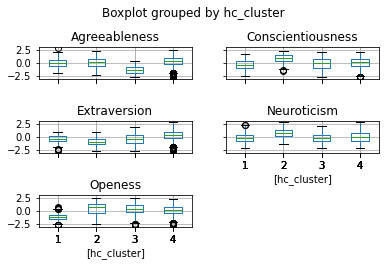

In [22]:
# 시각화방법 2
import matplotlib.pyplot as plt
data_prime.drop('silhouette_coeff', axis=1).boxplot(by='hc_cluster')
plt.tight_layout(pad=3, h_pad=1)
plt.show()

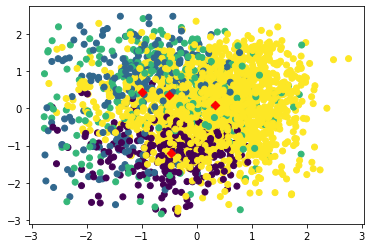

In [23]:
# 시각화방법 3
plt.scatter(x=data_prime['Extraversion'], y=data_prime['Openess'], c=data_prime['hc_cluster']) # 각 cluster 좌푯값 시각화

hc_centers = np.array(cluster_g.mean()) # 각 cluster별 centroid
plt.scatter(x=hc_centers[:,1], y=hc_centers[:,4], marker='D', c='r') # 각 cluster별 centroid 시각화
# marker='D', c='r' : 마커 모양은 Diamond, 색깔은 red
plt.set_xlabel('Extraversion', rotation=150)
plt.set_ylabel('Openess')
plt.show()

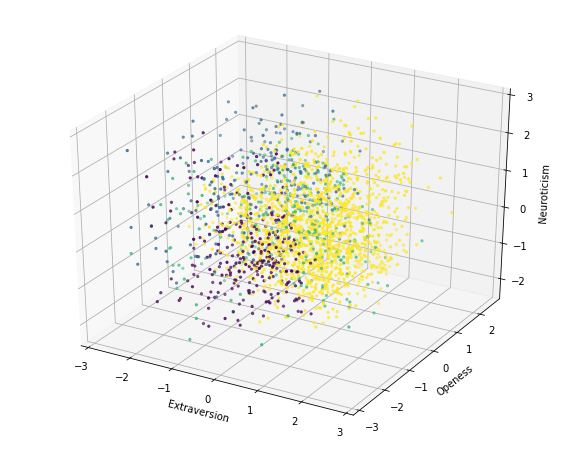

In [24]:
fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection = '3d')

ax.scatter(data_prime['Extraversion'], data_prime['Openess'], data_prime['Neuroticism'], s=5, c = data_prime['hc_cluster'])
ax.set_xlabel('Extraversion', rotation=150)
ax.set_ylabel('Openess')
ax.set_zlabel(r'Neuroticism', rotation=60)
plt.show()

# k-평균 클러스터링 (K-means Clustering)
- Euclidean space를 가정
- [과정](https://eunsukimme.github.io/ml/2019/12/16/K-Means/)  
  1) 클러스터의 개수 k를 선정  
  2) 데이터셋에서 k개의 centroids를 임의로 지정  
  3) 각 데이터들을 가장 가까운 centroids가 속한 그룹에 할당  
  4) 각 클러스터의 centroids 다시 계산 (일반적으로 유클리드 거리 사용)  
  5) 3, 4번 과정을 centroids가 더 이상 변하지 않을 때까지/지정된 횟수까지 반복  

- [한계](https://medium.com/h-document/%ED%81%B4%EB%9F%AC%EC%8A%A4%ED%84%B0%EB%A7%81-%EA%B5%B0%EC%A7%91-%EB%B6%84%EC%84%9D-%EB%B9%84-%EA%B3%84%EC%B8%B5%EC%A0%81-%EA%B5%B0%EC%A7%91-%EB%B6%84%EC%84%9D-ef1a96948d7d)
  - K 결정이 주관적
  - 여러 초기값이 동일 군집에 존재할 경우 최종 결과가 이상해질 수 있음
  - 크기가 작은 그룹에서는 제대로 작동하지 않을 수 있음
  - 반복 특성과 centroid를 random하게 초기화하기 때문에 local optimum에 고착, global optimum에 수렴되지 않을 수 있음

- Extensions
    - k-means에서 initial points로 비슷한 점들이 여러 개 선택되는 경우 불안정한 군집을 학습하게 됨 ([자세한 과정](https://lovit.github.io/nlp/machine%20learning/2018/03/19/kmeans_initializer/))
    - `k-means++`: 1) 첫 initial point를 임의로 선택, 2) 이후의 initial points는 과거 initial points와 멀리 떨어지도록 분포를 조절하여 진행
        - 문서의 bag of words와 같이, 고차원의 sparse 데이터를 군집화하는 과정에서, 대부분의 데이터 간 거리가 유사할 경우 k-means++를 적용하는 것은 expensive한 버전의 random sampling을 수행하는 것과 같음
    - `SphericalKMeans`: k-means++가 가지는 한계를 완화하기 위해 등장. 2)에서 다음 initial points가 멀리 떨어지도록 조절하는 과정에서 거리가 threshold 이하인 점들을 제거 후 random하게 initial points 선택
    - k-medoid: 임의의 점으로 초기화하는 kmeans와 달리 특정 점을 medoid로 사용  
      - large data에 잘 먹지 않을 수 있음
    - fuzzy c-means clustering (soft clustering)


In [25]:
data_prime = data.copy()

## Step 1. K 선정
1. EDA: 데이터의 형태를 살펴보고 manually 결정  
2. Elbow method: 클러스터의 개수를 늘려가며 SSE를 계산, SSE가 줄어드는 비율이 급격히 작아지는 부분을 elbow라 설정  
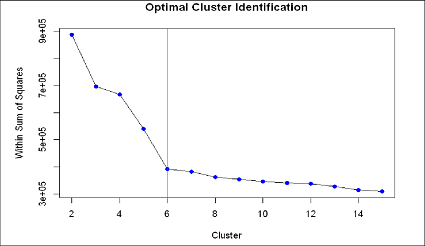
3. Silhouette score
4. Calinski Harabasz score: Variance Ratio Criterio이라고도 알려짐. between-clusters dispersion mean 과 within-cluster dispersion의 비율. 값이 높을수록 군집화가 잘 되었음을 의미
- 기타 지표 [참고](https://hongl.tistory.com/161)

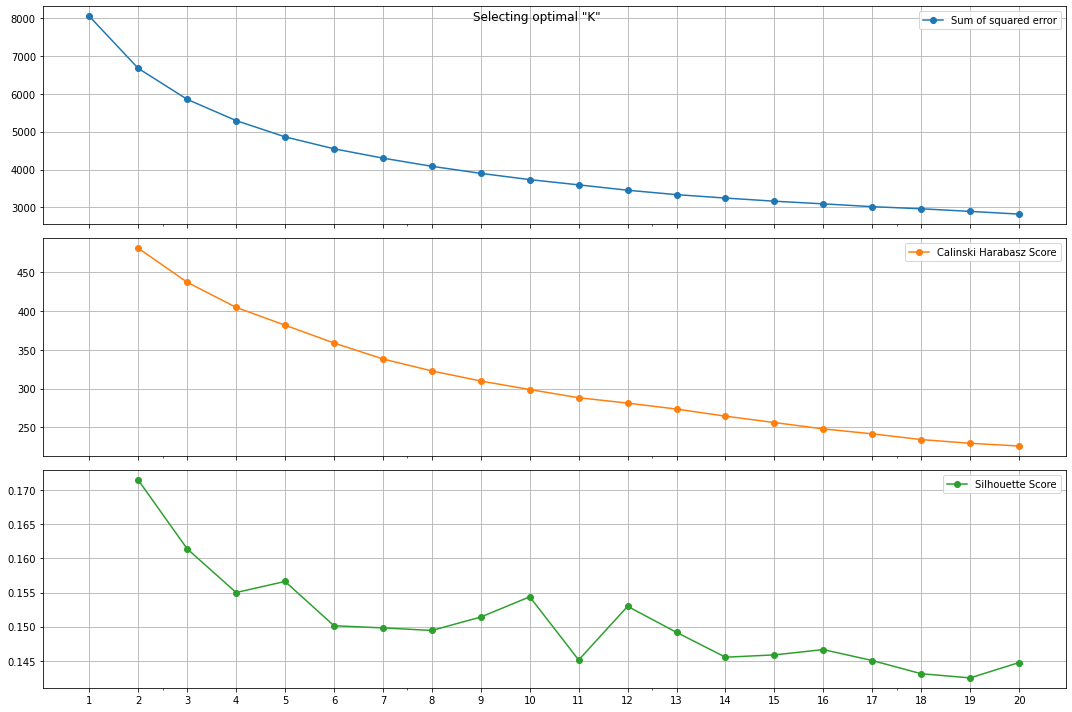

In [31]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score

search_range = range(1, 21)
report = {}
for k in search_range:
    temp_dict = {}
    kmeans = KMeans(init='k-means++',
                    algorithm='auto',
                    n_clusters=k,
                    max_iter=1000,
                    random_state=1,
                    verbose=0).fit(data_prime)
    inertia = kmeans.inertia_
    temp_dict['Sum of squared error'] = inertia
    try:
        cluster = kmeans.predict(data_prime)
        chs = calinski_harabasz_score(data_prime, cluster)
        ss = silhouette_score(data_prime, cluster)
        temp_dict['Calinski Harabasz Score'] = chs
        temp_dict['Silhouette Score'] = ss
        report[k] = temp_dict
    except:
        report[k] = temp_dict

report_df = pd.DataFrame(report).T
report_df.plot(figsize=(15, 10),
               xticks=search_range,
               grid=True,
               title=f'Selecting optimal "K"',
               subplots=True,
               marker='o',
               sharex=True)
plt.tight_layout()

## Step 2. K-means clustering

In [32]:
model = KMeans(n_clusters=5, random_state=312, algorithm='auto')
model.fit(data_prime)

KMeans(n_clusters=5, random_state=312)

In [33]:
# 각 군집(cluster) 표시
pred = model.predict(data_prime)
pred

array([3, 3, 4, ..., 4, 0, 2], dtype=int32)

In [34]:
# 군집별 centroids의 좌표값
centers = model.cluster_centers_
pd.DataFrame(centers, columns = data.columns)

,Neuroticism,Extraversion,Conscientiousness,Agreeableness,Openess
0,-0.747647,0.422308,0.522702,0.355185,0.267290
1,0.102650,-0.217124,0.229613,-0.212094,-1.008630
2,0.174221,-1.005625,0.000890,-0.619786,0.587663
3,-0.331343,0.106151,-1.030252,0.252091,-0.126438
4,1.107615,0.445493,0.117704,0.227376,0.267516


## Step 3. Evaluation

In [37]:
from sklearn.metrics import silhouette_samples, silhouette_score
data_prime['k_means_cluster'] = pred
data_prime['k_silhouette_coeff'] = silhouette_samples(data_prime, data_prime['k_means_cluster'])

k_average_score = silhouette_score(data_prime, data_prime['k_means_cluster'])
print('Average Silhouette Score:{0:.3f}'.format(k_average_score))

Average Silhouette Score:0.298


In [38]:
# 군집별 평균 silhouette_score 값
data_prime.groupby('k_means_cluster')['k_silhouette_coeff'].mean()

k_means_cluster
0    0.374042
1    0.233004
2    0.235230
3    0.278856
4    0.317717
Name: k_silhouette_coeff, dtype: float64

## Step 4. EDA

In [40]:
# 군집별 통계
data_prime.groupby('k_means_cluster').mean()

,Neuroticism,Extraversion,Conscientiousness,Agreeableness,Openess,k_silhouette_coeff
k_means_cluster,,,,,,
0,-0.747647,0.422308,0.522702,0.355185,0.267290,0.374042
1,0.102650,-0.217124,0.229613,-0.212094,-1.008630,0.233004
2,0.174221,-1.005625,0.000890,-0.619786,0.587663,0.235230
3,-0.331343,0.106151,-1.030252,0.252091,-0.126438,0.278856
4,1.107615,0.445493,0.117704,0.227376,0.267516,0.317717


- Cluster0: 신경질적이지 않고(-N) 성실한(C) 사람
- Cluster1: 개방적이지 않은(-O) 사람
- Cluster2: 외향적이지 않고(-E) 쾌활하지 않은(-A) 사람
- Cluster3: 성실하지 않은(-C) 사람
- Cluster4: 신경질적인(N) 사람

In [41]:
data_prime.groupby('k_means_cluster').std()

,Neuroticism,Extraversion,Conscientiousness,Agreeableness,Openess,k_silhouette_coeff
k_means_cluster,,,,,,
0,0.515664,0.595511,0.491930,0.622350,0.593479,0.092286
1,0.751084,0.718431,0.675426,0.724939,0.475892,0.085687
2,0.771411,0.626666,0.745757,0.748576,0.654246,0.089870
3,0.651125,0.757420,0.514657,0.679503,0.698537,0.093677
4,0.548380,0.657630,0.743163,0.665218,0.624678,0.091253


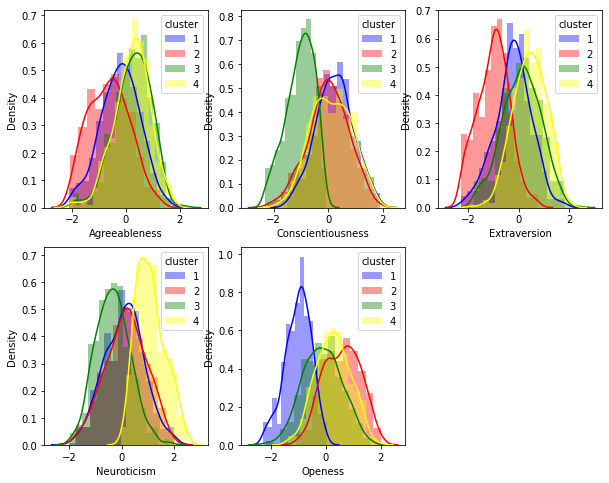

In [42]:
# 시각화방법 1
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8)) 
plt.subplot(2,3,1) 
sns.distplot(data_prime[data_prime.k_means_cluster == 1]["Agreeableness"], 
             color="blue", label=1)
sns.distplot(data_prime[data_prime.k_means_cluster == 2]["Agreeableness"], 
             color="red", label=2)
sns.distplot(data_prime[data_prime.k_means_cluster == 3]["Agreeableness"], 
             color="green", label=3)
sns.distplot(data_prime[data_prime.k_means_cluster == 4]["Agreeableness"], 
             color="yellow", label=4)
plt.legend(title="cluster")


plt.subplot(2,3,2) 
sns.distplot(data_prime[data_prime.k_means_cluster == 1]["Conscientiousness"], 
             color="blue", label=1)
sns.distplot(data_prime[data_prime.k_means_cluster == 2]["Conscientiousness"], 
             color="red", label=2)
sns.distplot(data_prime[data_prime.k_means_cluster == 3]["Conscientiousness"], 
             color="green", label=3)
sns.distplot(data_prime[data_prime.k_means_cluster == 4]["Conscientiousness"], 
             color="yellow", label=4)
plt.legend(title="cluster")


plt.subplot(2,3,3)
sns.distplot(data_prime[data_prime.k_means_cluster == 1]["Extraversion"], 
             color="blue", label=1)
sns.distplot(data_prime[data_prime.k_means_cluster == 2]["Extraversion"], 
             color="red", label=2)
sns.distplot(data_prime[data_prime.k_means_cluster == 3]["Extraversion"], 
             color="green", label=3)
sns.distplot(data_prime[data_prime.k_means_cluster == 4]["Extraversion"], 
             color="yellow", label=4)
plt.legend(title="cluster")


plt.subplot(2,3,4)
sns.distplot(data_prime[data_prime.k_means_cluster == 1]["Neuroticism"], 
             color="blue", label=1)
sns.distplot(data_prime[data_prime.k_means_cluster == 2]["Neuroticism"], 
             color="red", label=2)
sns.distplot(data_prime[data_prime.k_means_cluster == 3]["Neuroticism"], 
             color="green", label=3)
sns.distplot(data_prime[data_prime.k_means_cluster == 4]["Neuroticism"], 
             color="yellow", label=4)
plt.legend(title="cluster")

plt.subplot(2,3,5)
sns.distplot(data_prime[data_prime.k_means_cluster == 1]["Openess"], 
             color="blue", label=1)
sns.distplot(data_prime[data_prime.k_means_cluster == 2]["Openess"], 
             color="red", label=2)
sns.distplot(data_prime[data_prime.k_means_cluster == 3]["Openess"], 
             color="green", label=3)
sns.distplot(data_prime[data_prime.k_means_cluster == 4]["Openess"], 
             color="yellow", label=4)
plt.legend(title="cluster")

plt.show()

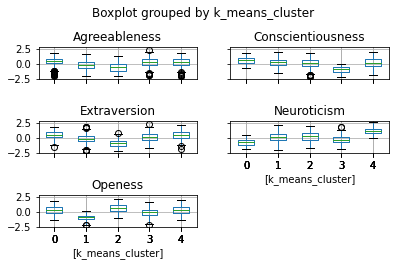

In [45]:
# 시각화방법 2
data_prime.drop('k_silhouette_coeff', axis=1).boxplot(by='k_means_cluster')
plt.tight_layout(pad=3, h_pad=1)
plt.show()

Text(0, 0.5, 'Agreeableness')

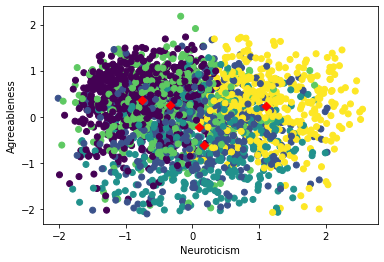

In [47]:
# 군집결과 시각화
plt.scatter(x=data_prime['Neuroticism'], y=data_prime['Agreeableness'], c=data_prime['k_means_cluster'])
plt.scatter(x=centers[:,0], y=centers[:,3], marker='D', c='r') # x, y는 각각 factor 1번째(0)와 4번째(3)
plt.xlabel('Neuroticism')
plt.ylabel('Agreeableness')

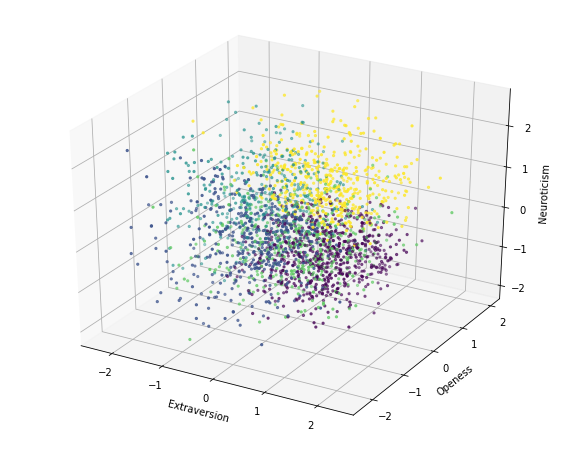

In [48]:
fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection = '3d')

ax.scatter(data_prime['Extraversion'], data_prime['Openess'], data_prime['Neuroticism'], s=5, c = data_prime['k_means_cluster'])
ax.set_xlabel('Extraversion', rotation=150)
ax.set_ylabel('Openess')
ax.set_zlabel(r'Neuroticism', rotation=60)
plt.show()